# Setup

## Imports

In [1]:
# If colab then setup else pass to rest of the code
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
    %cd /content/drive/MyDrive/Coding/spread-res/runscr/
except ImportError: pass

# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import os
import sys
import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import the model architecture
# from classes.models import BertGridNew

# Import the utilities and the dataloader
from utils import inferutil, setuputil, trainutil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)
# importlib.reload(BertGridNew)

# Import the model and funcs required from utils
# from classes.models.BertGridNew import BertGridNew
from utils.inferutil import infer_full, infer_one
from utils.setuputil import display_config, setup_config
from utils.trainutil import train_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Coding/spread-res/runscr


## Configuration

Default vars invisible below with their default values:

device = cuda/mps:0 (env-specific), threads = 1 to inf (env-specific), seed = 0 to inf, data_dir = ../data, rows = 100, cols = 100, tokens = 32, save_dir = ../models/

In [2]:
# Restart
from utils import setuputil

importlib.reload(setuputil)
from utils.setuputil import display_config, setup_config

# Setup the config
input_config = {
    # Environment and Model Info
    "env": "colab",
    "approach": "bert",
    "model_name": "BertGridNew",
    "model_base": "bert-base-cased",
    "data_ds": "100",
    # BERT Architecture Parameters
    "vocab_size": 30522,
    "hidden_size": 128,
    "num_hidden_layers": 1,
    "num_attention_heads": 1,
    "intermediate_size": 512,
    # Training Parameters
    "batch_size": 6,
    "lr": 1e-4,
    "mu": 0.25,
    "epochs": 50,
    "patience": 2,
    "save_int": 0,
}

# # Setup the config
# input_config = {
#     # Environment and Model Info
#     "env": "colab",
#     "approach": "bert",
#     "model_name": "BertGridNew",
#     "model_base": "bert-base-cased",
#     "data_ds": "manual",
#     # BERT Architecture Parameters
#     "vocab_size": 30522,
#     "hidden_size": 128,
#     "num_hidden_layers": 1,
#     "num_attention_heads": 1,
#     "intermediate_size": 512,
#     # Training Parameters
#     "batch_size": 4,
#     "lr": 1e-2,
#     "mu": 0.25,
#     "epochs": 20,
#     "patience": 2,
#     "save_int": 0,
# }

# input_config = {
#     # Environment and Model Info
#     "env": "local",
#     "approach": "bert",
#     "model_name": "BertGridTest",
#     "model_base": "bert-base-cased",
#     "data_ds": "manual",
#     # BERT Architecture Parameters
#     "vocab_size": 30522,
#     "hidden_size": 128,
#     "num_hidden_layers": 1,
#     "num_attention_heads": 1,
#     "intermediate_size": 512,
#     "gradient_checkpointing": False,
#     # Training Parameters
#     "batch_size": 4,
#     "lr": 1e-3,
#     "mu": 0.25,
#     "epochs": 10,
#     "patience": 2,
#     "save_int": 0,
# }
config = setup_config(input_config)
display_config(config)

# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]

# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config["model_base"]

# Training parameters
batch_size = config["batch_size"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

Processing files: 100%|██████████| 80/80 [00:13<00:00,  5.73it/s]



80(P) = 80(G) + 0(E)


Processing files: 100%|██████████| 10/10 [00:00<00:00, 5194.83it/s]



10(P) = 10(G) + 0(E)


Processing files: 100%|██████████| 10/10 [00:00<00:00, 5712.75it/s]



10(P) = 10(G) + 0(E)

FINAL CONFIG:
{
  "env": "colab",
  "approach": "bert",
  "DEVICE": "<device>",
  "THREADS": 10,
  "seed": 0,
  "model_base": "bert-base-cased",
  "model_name": "BertGridNew",
  "rows": 100,
  "cols": 100,
  "tokens": 32,
  "data_ds": "100",
  "data_dir": "../data",
  "train_dir": "../data/100_train",
  "val_dir": "../data/100_val",
  "test_dir": "../data/100_test",
  "tokenizer": "<BertTokenizerFast>",
  "vocab_size": 30522,
  "hidden_size": 128,
  "num_hidden_layers": 1,
  "num_attention_heads": 1,
  "intermediate_size": 512,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "max_position_embeddings": 64,
  "type_vocab_size": 2,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "pad_token_id": 0,
  "gradient_checkpointing": false,
  "train_loader": "<LoaderBert>",
  "val_loader": "<LoaderBert>",
  "test_loader": "<LoaderBert>",
  "batch_size": 6,
  "lr": 0.0001,
  "mu": 0.25,
  "epochs": 50,
  "patience": 2,


# NEW TESTER

## Model Creation -> Single Example Check

In [3]:
# Imports
import numpy as np
import torch
import torch.nn as nn
from transformers import BertConfig, BertModel
from transformers.models.bert.modeling_bert import BertEncoder


# Define the BertGridTest class
class BertGridNew(nn.Module):
    def __init__(self, config):
        super().__init__()
        torch.set_printoptions(precision=10, sci_mode=False)

        # Disable efficient sdp globally
        # torch.backends.cuda.enable_mem_efficient_sdp(False)

        # Extract common params
        self.device = config["DEVICE"]
        self.rows = config["rows"]
        self.cols = config["cols"]
        self.seq_len = config["tokens"]
        self.hidden_size = config["hidden_size"]
        self.hidden_dropout_prob = config["hidden_dropout_prob"]

        # Create config to be used for both base model and encoder
        self.bert_config = BertConfig(
            vocab_size=config["vocab_size"],
            hidden_size=self.hidden_size,
            intermediate_size=config["intermediate_size"],
            num_hidden_layers=config["num_hidden_layers"],
            num_attention_heads=config["num_attention_heads"],
            hidden_act=config["hidden_act"],
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=config["attention_probs_dropout_prob"],
            max_position_embeddings=config["max_position_embeddings"],
            type_vocab_size=config["type_vocab_size"],
            layer_norm_eps=config["layer_norm_eps"],
            initializer_range=config["initializer_range"],
            pad_token_id=config["pad_token_id"],
            gradient_checkpointing=config["gradient_checkpointing"],
            seed=config["seed"],
        )

        # Initialize both the BERT model and the enriched encoder using the same config.
        self.bertModel_cell = BertModel(self.bert_config)
        self.bertEncoder_spatial = BertEncoder(self.bert_config)

        # Precompute the exponential term in posenc formula
        self.exp_term = torch.exp(
            -torch.arange(self.hidden_size, device=self.device)
            * torch.log(torch.tensor(10000.0))
            / self.hidden_size
        )

        # Timing positional encoding from postest
        self.pos_encodings = self.get_posEncoding(self.rows, self.cols)

        # Final binary classification layers wrapped sequentially
        self.binary_classifier = nn.Sequential(
            nn.Dropout(self.hidden_dropout_prob),
            nn.GELU(),
            nn.Linear(self.hidden_size, 1),
        )

    def get_posEncoding(self, num_rows, num_cols):
        positions = torch.arange(num_rows * num_cols, device=self.device)

        # Precompute row and column indices just once
        i = (positions // num_cols).unsqueeze(1)
        j = (positions % num_cols).unsqueeze(1)

        # Precompute scaled indices to avoid recomputation
        i_term = i * self.exp_term
        j_term = j * self.exp_term

        # Inline evenness check and sine/cosine selections directly
        return (
            torch.where((i & 1) == 0, torch.sin(i_term), torch.cos(i_term))
            + torch.where((j & 1) == 0, torch.sin(j_term), torch.cos(j_term))
        ).unsqueeze(0)

    # Old forward method
    def forward(self, input_ids, attention_mask):
        # Retrieve dims
        batch_size, rows, cols, seq_len = input_ids.shape

        # Generate the S_cube and return directly
        return (
            self.binary_classifier(
                self.bertEncoder_spatial(
                    (
                        (
                            self.bertModel_cell(
                                input_ids=input_ids.reshape(-1, seq_len),
                                attention_mask=attention_mask.reshape(-1, seq_len),
                            ).pooler_output.reshape(
                                batch_size, rows * cols, self.hidden_size
                            )
                        )
                        + (self.pos_encodings.to(input_ids.device))
                    )
                )[0]
            )
            .squeeze(-1)
            .reshape(batch_size, rows, cols)
        )

In [4]:
# # Import the funcs for comparing
# from utils.selfutil import compare_sCube, oneBatch_check
# import time

# # Get the example batch values
# ex_file, ex_xtok, ex_xmasks, ex_ytok = oneBatch_check(
#     batch_size=2, data_loader=train_loader, device=DEVICE
# )

# # Create model and do forward
# untrained_model = BertGridTest(config).to(DEVICE)
# untrained_model.eval()

# with torch.no_grad():
#     # start_time_forward2 = time.time()
#     # out2 = untrained_model.forward2(ex_xtok, ex_xmasks)
#     # elapsed_forward2 = time.time() - start_time_forward2
#     # print(f"NEW forward2: {elapsed_forward2:.3f} seconds")

#     start_time_forward = time.time()
#     out = untrained_model.forward(ex_xtok, ex_xmasks)
#     elapsed_forward = time.time() - start_time_forward
#     print(f"OLD forward: {elapsed_forward:.3f} seconds")

# # Compare if applicable
# # compare_sCube(out, out2, ex_file, tolerance=1e-6)

# Model Training

In [5]:
# Create and observe the model
untrained_model = BertGridNew(config).to(DEVICE)
#print(untrained_model)

## Training Metrics

1. GPU Model: 539 mb
2. GPU Training: 36.7 gb

3. Per Epoch Train Time: 38s
4. Per Epoch Val Time: 15s
5. Last Epoch: 16


In [6]:
# Train with adjusted batch size
trained_model = train_model(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=batch_size,
    lr=lr,
    mu=mu,
    max_epochs=epochs,
    patience=patience,
    save_int=save_int,
    save_dir=save_dir,
    save_name=save_name,
    config=config,
    isPerp=False,
)

Epoch 0


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Train Loss: 1.4663e+00, Perplexity: 1.0000e+00
Val Loss: 1.3468e+00, Perplexity: 1.0000e+00


Epoch 1


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 1.3730e+00, Perplexity: 1.0000e+00
Val Loss: 1.2576e+00, Perplexity: 1.0000e+00


Epoch 2


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 1.2012e+00, Perplexity: 1.0000e+00
Val Loss: 1.2093e+00, Perplexity: 1.0000e+00


Epoch 3


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Train Loss: 1.2088e+00, Perplexity: 1.0000e+00
Val Loss: 1.1696e+00, Perplexity: 1.0000e+00


Epoch 4


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 1.1609e+00, Perplexity: 1.0000e+00
Val Loss: 1.1379e+00, Perplexity: 1.0000e+00


Epoch 5


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Train Loss: 1.1489e+00, Perplexity: 1.0000e+00
Val Loss: 1.1073e+00, Perplexity: 1.0000e+00


Epoch 6


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Train Loss: 1.1663e+00, Perplexity: 1.0000e+00
Val Loss: 1.0833e+00, Perplexity: 1.0000e+00


Epoch 7


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 1.1600e+00, Perplexity: 1.0000e+00
Val Loss: 1.0622e+00, Perplexity: 1.0000e+00


Epoch 8


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Train Loss: 1.1438e+00, Perplexity: 1.0000e+00
Val Loss: 1.0435e+00, Perplexity: 1.0000e+00


Epoch 9


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Train Loss: 1.1037e+00, Perplexity: 1.0000e+00
Val Loss: 1.0249e+00, Perplexity: 1.0000e+00


Epoch 10


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


Train Loss: 1.0379e+00, Perplexity: 1.0000e+00
Val Loss: 1.0099e+00, Perplexity: 1.0000e+00


Epoch 11


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Train Loss: 1.0284e+00, Perplexity: 1.0000e+00
Val Loss: 9.9597e-01, Perplexity: 1.0000e+00


Epoch 12


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Train Loss: 1.0278e+00, Perplexity: 1.0000e+00
Val Loss: 9.8006e-01, Perplexity: 1.0000e+00


Epoch 13


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


Train Loss: 1.0393e+00, Perplexity: 1.0000e+00
Val Loss: 9.6517e-01, Perplexity: 1.0000e+00


Epoch 14


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 1.0299e+00, Perplexity: 1.0000e+00
Val Loss: 9.4939e-01, Perplexity: 1.0000e+00


Epoch 15


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


Train Loss: 9.7609e-01, Perplexity: 1.0000e+00
Val Loss: 9.3059e-01, Perplexity: 1.0000e+00


Epoch 16


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


Train Loss: 9.6107e-01, Perplexity: 1.0000e+00
Val Loss: 9.1219e-01, Perplexity: 1.0000e+00


Epoch 17


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 1.0092e+00, Perplexity: 1.0000e+00
Val Loss: 8.9390e-01, Perplexity: 1.0000e+00


Epoch 18


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Train Loss: 9.3437e-01, Perplexity: 1.0000e+00
Val Loss: 8.7681e-01, Perplexity: 1.0000e+00


Epoch 19


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 9.2144e-01, Perplexity: 1.0000e+00
Val Loss: 8.5676e-01, Perplexity: 1.0000e+00


Epoch 20


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


Train Loss: 9.8850e-01, Perplexity: 1.0000e+00
Val Loss: 8.3712e-01, Perplexity: 1.0000e+00


Epoch 21


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Train Loss: 9.7562e-01, Perplexity: 1.0000e+00
Val Loss: 8.2286e-01, Perplexity: 1.0000e+00


Epoch 22


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


Train Loss: 8.7419e-01, Perplexity: 1.0000e+00
Val Loss: 8.0541e-01, Perplexity: 1.0000e+00


Epoch 23


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Train Loss: 8.7480e-01, Perplexity: 1.0000e+00
Val Loss: 7.8481e-01, Perplexity: 1.0000e+00


Epoch 24


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Train Loss: 8.5982e-01, Perplexity: 1.0000e+00
Val Loss: 7.6282e-01, Perplexity: 1.0000e+00


Epoch 25


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


Train Loss: 8.4726e-01, Perplexity: 1.0000e+00
Val Loss: 7.4262e-01, Perplexity: 1.0000e+00


Epoch 26


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


Train Loss: 8.0912e-01, Perplexity: 1.0000e+00
Val Loss: 7.2397e-01, Perplexity: 1.0000e+00


Epoch 27


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Train Loss: 7.8524e-01, Perplexity: 1.0000e+00
Val Loss: 7.0427e-01, Perplexity: 1.0000e+00


Epoch 28


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Train Loss: 7.9128e-01, Perplexity: 1.0000e+00
Val Loss: 6.7948e-01, Perplexity: 1.0000e+00


Epoch 29


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Train Loss: 7.4331e-01, Perplexity: 1.0000e+00
Val Loss: 6.6294e-01, Perplexity: 1.0000e+00


Epoch 30


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Train Loss: 7.3182e-01, Perplexity: 1.0000e+00
Val Loss: 6.4374e-01, Perplexity: 1.0000e+00


Epoch 31


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Train Loss: 7.2286e-01, Perplexity: 1.0000e+00
Val Loss: 6.2512e-01, Perplexity: 1.0000e+00


Epoch 32


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 6.9050e-01, Perplexity: 1.0000e+00
Val Loss: 5.9980e-01, Perplexity: 1.0000e+00


Epoch 33


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 6.6822e-01, Perplexity: 1.0000e+00
Val Loss: 5.7842e-01, Perplexity: 1.0000e+00


Epoch 34


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Train Loss: 6.5419e-01, Perplexity: 1.0000e+00
Val Loss: 5.6075e-01, Perplexity: 1.0000e+00


Epoch 35


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


Train Loss: 6.3955e-01, Perplexity: 1.0000e+00
Val Loss: 5.4231e-01, Perplexity: 1.0000e+00


Epoch 36


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 6.3304e-01, Perplexity: 1.0000e+00
Val Loss: 5.2444e-01, Perplexity: 1.0000e+00


Epoch 37


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 6.0542e-01, Perplexity: 1.0000e+00
Val Loss: 5.0570e-01, Perplexity: 1.0000e+00


Epoch 38


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


Train Loss: 5.8553e-01, Perplexity: 1.0000e+00
Val Loss: 4.8699e-01, Perplexity: 1.0000e+00


Epoch 39


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 6.1854e-01, Perplexity: 1.0000e+00
Val Loss: 4.6875e-01, Perplexity: 1.0000e+00


Epoch 40


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


Train Loss: 5.5627e-01, Perplexity: 1.0000e+00
Val Loss: 4.5233e-01, Perplexity: 1.0000e+00


Epoch 41


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Train Loss: 5.4849e-01, Perplexity: 1.0000e+00
Val Loss: 4.3636e-01, Perplexity: 1.0000e+00


Epoch 42


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Train Loss: 5.1921e-01, Perplexity: 1.0000e+00
Val Loss: 4.2020e-01, Perplexity: 1.0000e+00


Epoch 43


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


Train Loss: 5.1956e-01, Perplexity: 1.0000e+00
Val Loss: 4.0716e-01, Perplexity: 1.0000e+00


Epoch 44


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 4.9179e-01, Perplexity: 1.0000e+00
Val Loss: 3.9313e-01, Perplexity: 1.0000e+00


Epoch 45


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Train Loss: 4.8119e-01, Perplexity: 1.0000e+00
Val Loss: 3.8201e-01, Perplexity: 1.0000e+00


Epoch 46


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 4.6800e-01, Perplexity: 1.0000e+00
Val Loss: 3.6996e-01, Perplexity: 1.0000e+00


Epoch 47


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Train Loss: 4.5945e-01, Perplexity: 1.0000e+00
Val Loss: 3.5821e-01, Perplexity: 1.0000e+00


Epoch 48


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Train Loss: 4.6655e-01, Perplexity: 1.0000e+00
Val Loss: 3.4827e-01, Perplexity: 1.0000e+00


Epoch 49


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

Train Loss: 4.3411e-01, Perplexity: 1.0000e+00
Val Loss: 3.3882e-01, Perplexity: 1.0000e+00



TRAINING DONE at epoch 49, best epoch 49
Train Loss = 0.4341139442154339, Perplexity = 1.000007235258578
Val Loss = 0.33881939947605133, Perplexity = 1.0000056470059355


# Evaluation

In [20]:
# Params
loc = 0
thresh = 0.9

# # Load the pretrained weights and assign to trained model
# untrained_model.load_state_dict(
#     torch.load(
#         "../models/ber0c_bbcBertPos_manual10010032_ba40lr1e-2ep20pa2_v30kh32l1i128a1_20250210_210415.pth",
#         map_location=DEVICE,
#         weights_only=True,
#     )
# )
# trained_model = untrained_model.eval()

## Single Example


Filename: ../data/100_train/ALFA_Parameters.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(11,3): 0.693044 | (21,1): 0.700493 | (8,5): 0.817300 | (24,0): 0.891324 | (2,2): 0.908219 | (18,4): 0.917911 | (5,1): 0.922912

NB to B ratio: Predicted = 9957:43 | Actual = 9993:7
Accuracy: 99.56% | Precision: 6.98% | Recall: 42.86% | F1-Score: 0.12



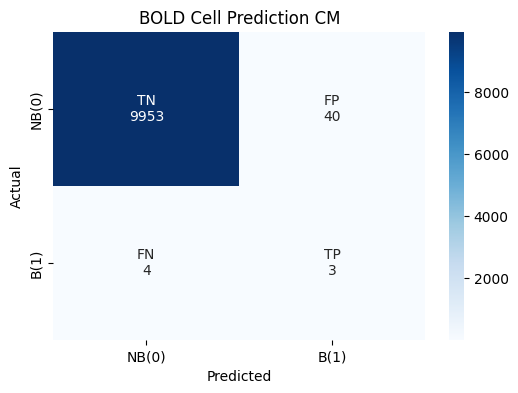


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6
0,1,1,1,1,1,1,1
1,0,1,1,1,1,1,0
2,1,1,1,1,1,1,0
4,0,1,1,1,0,1,0
5,1,1,1,0,1,0,0
7,0,1,1,0,1,0,1
8,1,0,0,0,0,0,0
10,0,1,0,0,0,0,0
13,0,0,1,0,1,0,0
14,1,1,1,0,1,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5
2,0,0,1,0,0,0
5,0,1,0,0,0,0
8,0,0,0,0,0,1
11,0,0,0,1,0,0
18,0,0,0,0,1,0
21,0,1,0,0,0,0
24,1,0,0,0,0,0


In [21]:
# Inference on single position of train_loader
infer_one(
    trained_model=trained_model,
    infer_loader=train_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)


Filename: ../data/100_val/LMDI_Combined.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
No bold cells in the actual data.

NB to B ratio: Predicted = 9961:39 | Actual = 10000:0
Accuracy: 99.61% | Precision: 0.00% | Recall: 0.00% | F1-Score: 0.00



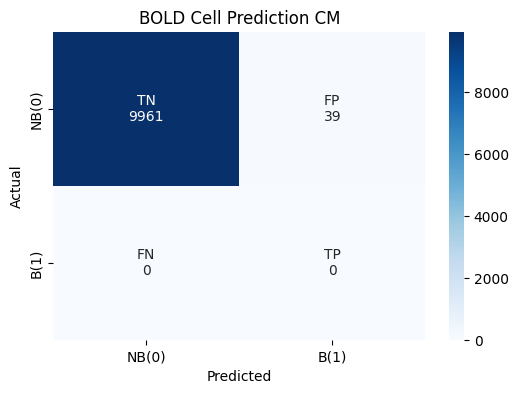


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,0
4,1,1,1,1
5,0,1,1,0
6,0,1,1,1
9,0,1,1,0
10,1,1,0,1
12,1,0,0,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---
No bold cells in actual data.


In [22]:
# Inference on single position of val_loader
infer_one(
    trained_model=trained_model,
    infer_loader=val_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)


Filename: ../data/100_test/1415-bassessment-1.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(8,6): 0.840388 | (8,5): 0.865810 | (8,0): 0.883432 | (8,4): 0.884022 | (8,3): 0.889777 | (8,2): 0.899133 | (8,1): 0.914115 | (6,0): 0.916664

NB to B ratio: Predicted = 9965:35 | Actual = 9992:8
Accuracy: 99.61% | Precision: 5.71% | Recall: 25.00% | F1-Score: 0.09



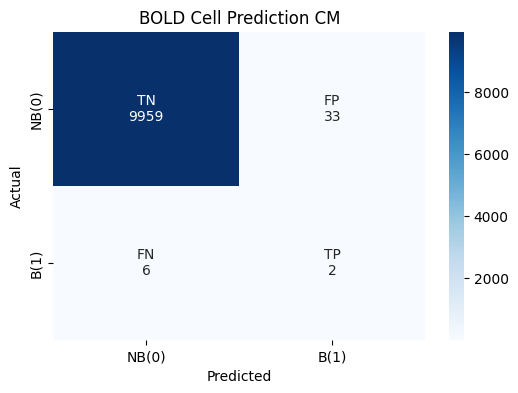


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,4,6
0,1,1,0,0,0
1,1,1,0,0,0
2,1,1,0,0,0
3,1,1,0,0,0
4,1,1,0,0,0
6,1,0,0,0,0
8,0,1,0,0,0
9,0,0,1,1,1
10,0,1,0,0,0
11,0,0,1,1,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6
6,1,0,0,0,0,0,0
8,1,1,1,1,1,1,1


In [23]:
# Inference on single position of test_loader
infer_one(
    trained_model=trained_model,
    infer_loader=test_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)

## All Examples

Batch Inference: 100%|██████████| 14/14 [00:02<00:00,  5.07it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 796685:3315 | Actual = 798240:1760
Accuracy: 99.50% | Precision: 18.98% | Recall: 40.44% | F1-Score: 0.24



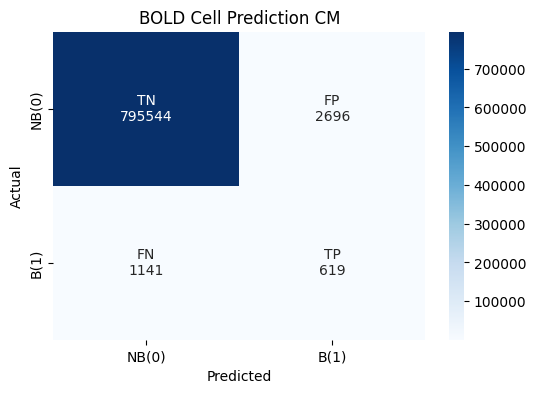

In [38]:
thresh = 0.9
# Infer across all examples of train_loader
infer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 99507:493 | Actual = 99799:201
Accuracy: 99.52% | Precision: 26.68% | Recall: 50.32% | F1-Score: 0.29



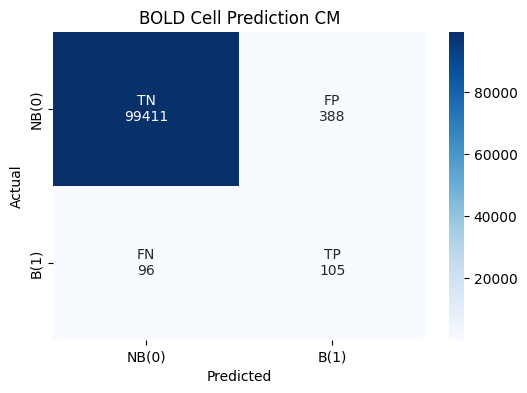

In [39]:
# Infer across all examples of val_loader
infer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 99483:517 | Actual = 99738:262
Accuracy: 99.47% | Precision: 22.25% | Recall: 43.67% | F1-Score: 0.29



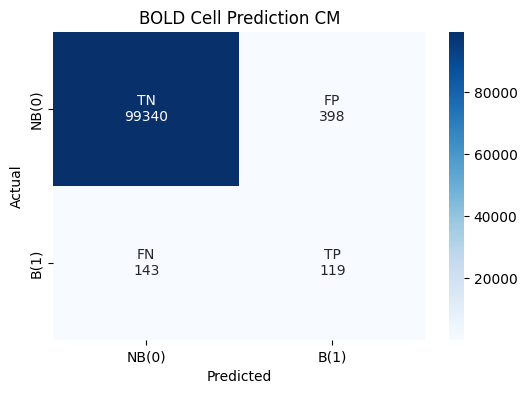

In [40]:
# Infer across all examples of test_loader
infer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)